# What makes a good predictor of home prices?

In [27]:
# Import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('seaborn-colorblind')
%matplotlib inline

In [3]:
# Read in cleaned Kings County file 
df = pd.read_csv("cleaned_kings.csv")
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,01/01/1970,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,01/01/1970,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,01/01/1970,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,01/01/1970,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,01/01/1970,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Evaluate outliers
It seems there are very few highly priced homes that would negatively impact a prediction model. Let's take out the top priced homes for a representative model. According to the box plot below we have significant outliers.

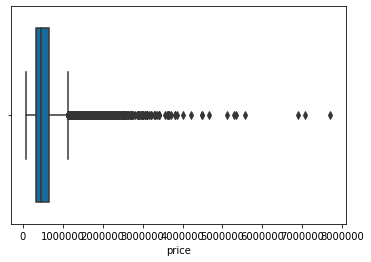

In [5]:
# Create boxplot for price
sns.boxplot(x='price', data=df);

## Remove outliers
Outliers prevent the possibility of model prediction. 

1125075.0

Text(0.5, 1.0, 'Price (without price outliers)')

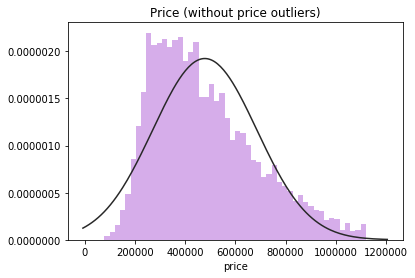

20268 21420
Number of homes excluded is 1152
Reduced homes by 5%


Text(0.5, 1.0, 'Price of Higher Priced Homes')

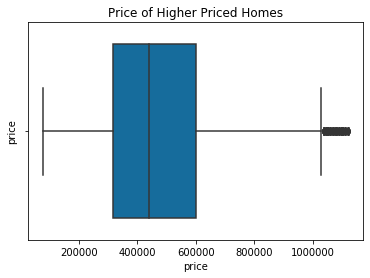

In [7]:
# Calculate the price limit for outliers using 1.5 * IQR + Q3
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
limit = 1.5 * IQR + Q3
limit

# Remove upper outliers from sqft_lot and create histogram again
df_price = df[df['price'] < limit]

# Histogram (distplot)
sns.distplot(df_price['price'], color='darkorchid', label=df_price, fit=norm, kde=False)
plt.title('Price (without price outliers)')
plt.show()
print(len(df_price), len(df))
print('Number of homes excluded is ' + str(len(df) - len(df_price)))
print('Reduced homes by ' + str(round(100 - len(df_price) / len(df) * 100)) + '%')

sns.scatterplot(x="zipcode", y="price", data=df_price)
sns.boxplot(x='price', data=df_price);
plt.title('Price of Higher Priced Homes')
plt.show()

The histogram and box plot above show a more normal set of data values for us to evaluate. Let's now use pairwise plots between our given conditions and price to see if there are any linear relationships to explore.

## A check for linear relationships

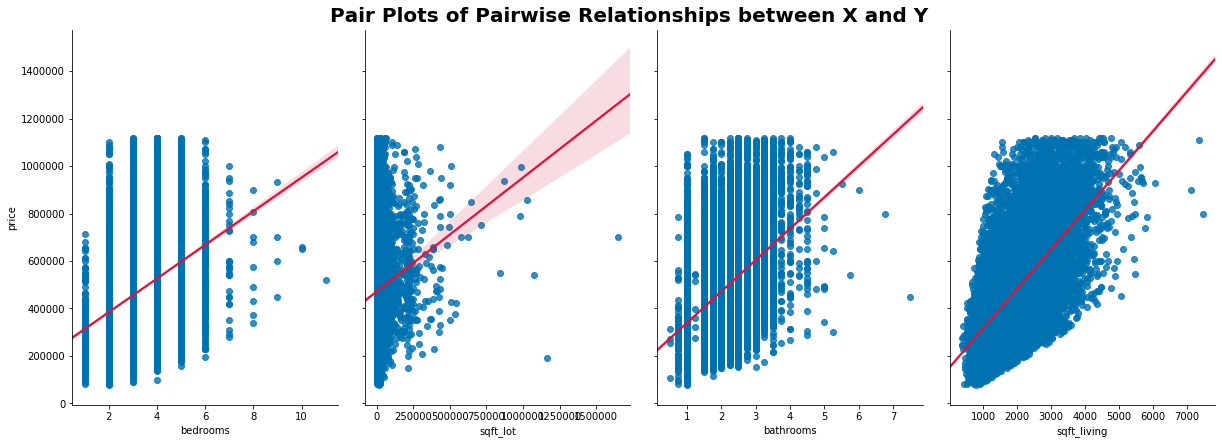

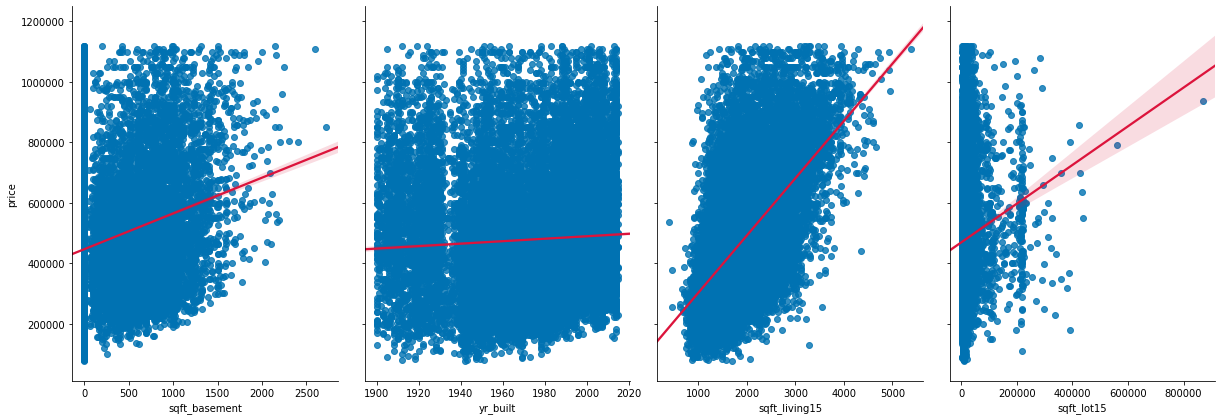

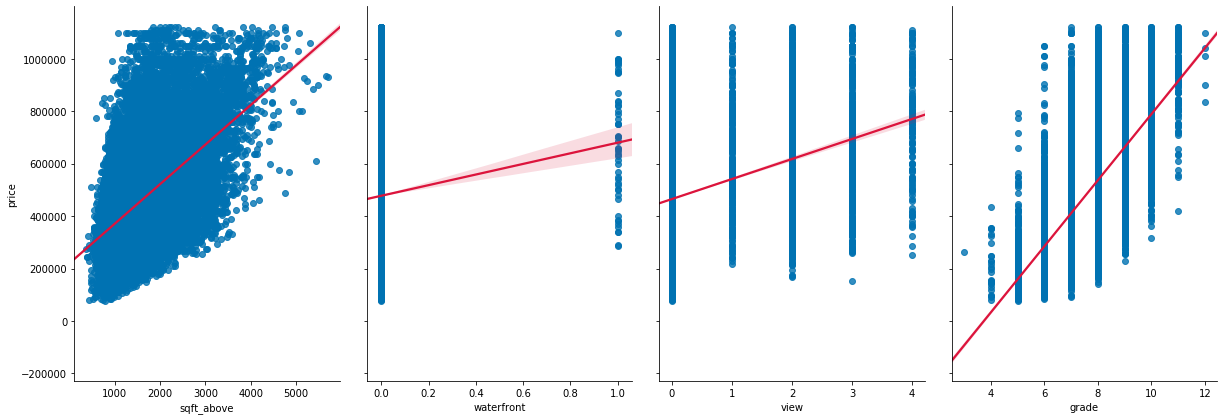

In [8]:
# visualize the pairwise relationship between the features and the response using pairplots 

sns.pairplot(x_vars=['bedrooms', 'sqft_lot', 'bathrooms', 'sqft_living'], y_vars='price', data=df_price, 
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)

plt.suptitle('Pair Plots of Pairwise Relationships between X and Y', size=20, weight='bold', y=1.02)

sns.pairplot(x_vars=['sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15'], y_vars='price', data=df_price, 
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)
sns.pairplot(x_vars=['sqft_above', 'waterfront', 'view', 'grade'], y_vars='price', data=df_price, 
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)
plt.show();

A few of the graphs seem to have a good linear relationship: bedrooms, bathrooms, sqft_living, sqft_living15, sqft_above, and grade. After checking for normality, let's evaluate these relationships.

## A check for normality

In [9]:
# First well limit our set to the indicated features
data = df_price[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 'sqft_above', 'grade']]


In [10]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_living15,sqft_above,grade
0,221900.0,3,1.00,1180,1340,1180,7
1,538000.0,3,2.25,2570,1690,2170,7
2,180000.0,2,1.00,770,2720,770,6
3,604000.0,4,3.00,1960,1360,1050,7
4,510000.0,3,2.00,1680,1800,1680,8


Text(0.5, 1.0, 'price')

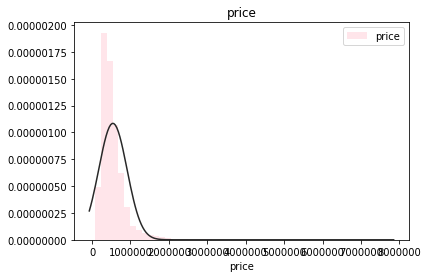

Text(0.5, 1.0, 'bedrooms')

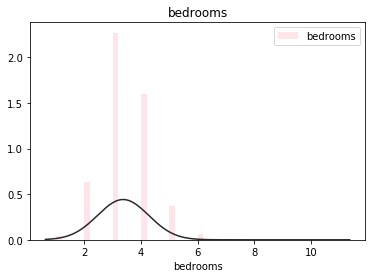

Text(0.5, 1.0, 'bathrooms')

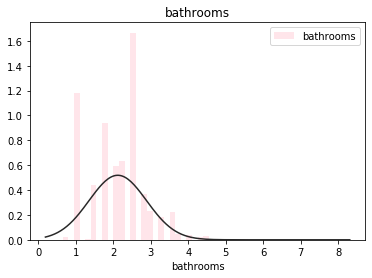

Text(0.5, 1.0, 'sqft_living')

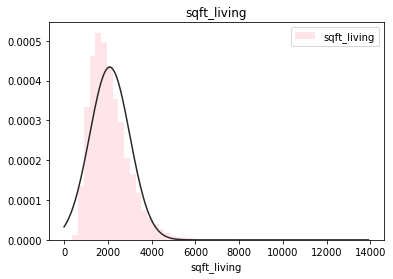

Text(0.5, 1.0, 'sqft_living15')

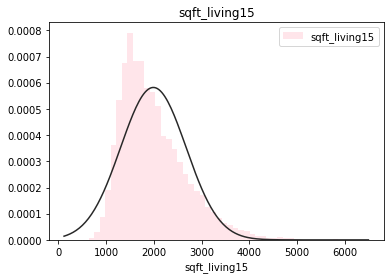

Text(0.5, 1.0, 'sqft_above')

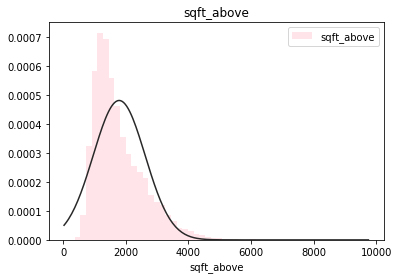

Text(0.5, 1.0, 'grade')

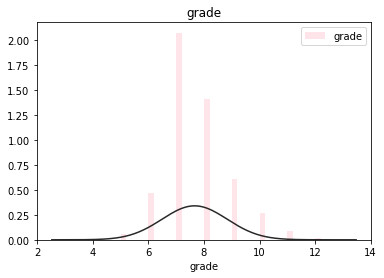

In [11]:
# Create a loop to display all the histograms
for item in data:
    sns.distplot(df[item], color='pink', label=item, fit=norm, kde=False)
    plt.title(item)
    plt.legend()
    plt.show()

All features seem relatively normal except bathrooms. 

## Let's check for any type of correlation

<Figure size 576x432 with 0 Axes>

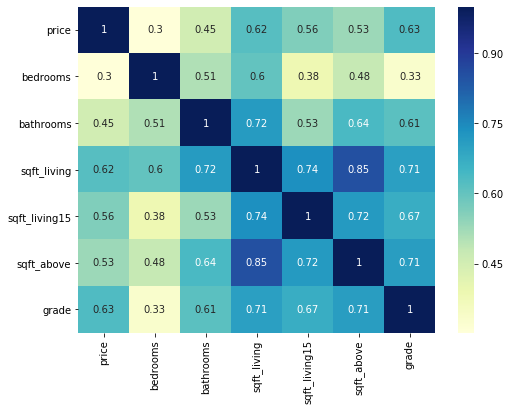

In [12]:
# heatmap to show relationships
plt.figure(figsize=(8,6))
sns.heatmap(data.corr().abs(), annot=True, cmap='YlGnBu')
plt.autoscale()
plt.show()

## Explore features 

In [14]:
# Set the dependent and independent data sets
X = data.drop(columns='price')
y = data.price

In [15]:
# Explore with intercept
X_fin = X[['bedrooms', 'sqft_above', 'sqft_living15', 'grade', 'sqft_living', 'bathrooms']]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     3071.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        00:52:08   Log-Likelihood:            -2.7034e+05
No. Observations:               20268   AIC:                         5.407e+05
Df Residuals:                   20261   BIC:                         5.407e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -2.84e+05   9931.405    -28.600      0.000   -3.04e+05   -2.65e+05
bedrooms      -1.138e+04   1544.299     -7.370      0.000   -1.44e+04   -8355.051
sqft_above      -57.5929      2.956    -19.484      0.000     -63.387     -51.799
sqft_living15    43.8678      2.732     16.059      0.000      38.513      49.222
grade          7.766e+04   1618.837     47.970      0.000    7.45e+04    8.08e+04
sqft_living     130.9377      3.292     39.775      0.000     124.485     137.390
bathrooms      -1.46e+04   2223.153     -6.565      0.000    -1.9e+04   -1.02e+04
==============================================================================
Omnibus:                     1101.460   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1326.740
Skew:                           0.569   Prob(JB):                    7.98e-289
Kurtosis:                       3.527   Cond. No.                     3.28e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# Explore without intercept
ols = sm.OLS(y, X)
res = ols.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                          3.575e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):                        0.00
Time:                        00:56:00   Log-Likelihood:                     -2.7074e+05
No. Observations:               20268   AIC:                                  5.415e+05
Df Residuals:                   20262   BIC:                                  5.415e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -3.085e+04   1413.820    -21.822      0.000   -3.36e+04   -2.81e+04
bathrooms     -8560.8413   2257.292     -3.793      0.000    -1.3e+04   -4136.366
sqft_living     154.2065      3.253     47.398      0.000     147.829     160.584
sqft_living15    44.8050      2.786     16.082      0.000      39.344      50.266
sqft_above      -41.3298      2.959    -13.969      0.000     -47.129     -35.531
grade          3.731e+04    809.829     46.070      0.000    3.57e+04    3.89e+04
==============================================================================
Omnibus:                     1232.302   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1479.066
Skew:                           0.626   Prob(JB):                         0.00
Kurtosis:                       3.427   Cond. No.                     7.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b>Without intercept looks promising. However, the high condition number suggests there may be multicollinearity. The highest correlating factors with price are grade and sqft_living. Here bedrooms also shows a low correlation so I will remove bedrooms as an evaluation feature.</b>

In [18]:
# Drop bedrooms due to low correlation
data = data.drop(['bedrooms'], axis=1)
data.head(2)

,price,bathrooms,sqft_living,sqft_living15,sqft_above,grade
0,221900.0,1.00,1180,1340,1180,7
1,538000.0,2.25,2570,1690,2170,7


## Create an OLS regression model to evaluate features
### Individual Regression Comparisons

In [17]:
# Create the OLS model by looping through each feature and create a summary table
summaries = []
for feature in data:
    d = {}
    formula_str = 'price ~ ' + str(feature)
    res = ols(formula=formula_str, data=data).fit()
    # Make a summary chart
    d['feature'] = feature
    d['intcept'], d['t'] = res.tvalues
    d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
    d['r2'] = res.rsquared
    summaries.append(d)
    res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.044e+35
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:06   Log-Likelihood:             4.5060e+05
No. Observations:               20268   AIC:                        -9.012e+05
Df Residuals:                   20266   BIC:                        -9.012e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.095e-11   9.45e-13     96.280      0.000    8.91e-11    9.28e-11
price          1.0000   1.81e-18   5.52e+17      0.000       1.000       1.000
==============================================================================
Omnibus:                     7528.909   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28298.602
Skew:                           1.863   Prob(JB):                         0.00
Kurtosis:                       7.431   Cond. No.                     1.31e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     5242.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:06   Log-Likelihood:            -2.7456e+05
No. Observations:               20268   AIC:                         5.491e+05
Df Residuals:                   20266   BIC:                         5.491e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.059e+05   3977.747     51.761      0.000    1.98e+05    2.14e+05
bathrooms   1.325e+05   1830.136     72.405      0.000    1.29e+05    1.36e+05
==============================================================================
Omnibus:                     1228.339   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1464.800
Skew:                           0.657   Prob(JB):                         0.00
Kurtosis:                       3.091   Cond. No.                         7.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                 1.270e+04
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:06   Log-Likelihood:            -2.7196e+05
No. Observations:               20268   AIC:                         5.439e+05
Df Residuals:                   20266   BIC:                         5.439e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.493e+05   3133.295     47.639      0.000    1.43e+05    1.55e+05
sqft_living   166.2642      1.475    112.711      0.000     163.373     169.156
==============================================================================
Omnibus:                      904.210   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1028.481
Skew:                           0.542   Prob(JB):                    4.66e-224
Kurtosis:                       3.212   Cond. No.                     5.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     9316.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:06   Log-Likelihood:            -2.7306e+05
No. Observations:               20268   AIC:                         5.461e+05
Df Residuals:                   20266   BIC:                         5.461e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.141e+05   3959.970     28.804      0.000    1.06e+05    1.22e+05
sqft_living15   189.2377      1.961     96.519      0.000     185.395     193.081
==============================================================================
Omnibus:                     1529.103   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1913.742
Skew:                           0.708   Prob(JB):                         0.00
Kurtosis:                       3.511   Cond. No.                     6.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     7863.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:06   Log-Likelihood:            -2.7357e+05
No. Observations:               20268   AIC:                         5.471e+05
Df Residuals:                   20266   BIC:                         5.472e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.203e+05   3159.526     69.729      0.000    2.14e+05    2.27e+05
sqft_above   150.7173      1.700     88.672      0.000     147.386     154.049
==============================================================================
Omnibus:                     1255.124   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1498.417
Skew:                           0.658   Prob(JB):                         0.00
Kurtosis:                       3.211   Cond. No.                     4.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                 1.330e+04
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:06   Log-Likelihood:            -2.7178e+05
No. Observations:               20268   AIC:                         5.436e+05
Df Residuals:                   20266   BIC:                         5.436e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.724e+05   8320.673    -56.773      0.000   -4.89e+05   -4.56e+05
grade       1.261e+05   1093.914    115.307      0.000    1.24e+05    1.28e+05
==============================================================================
Omnibus:                     1326.979   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1620.107
Skew:                           0.649   Prob(JB):                         0.00
Kurtosis:                       3.485   Cond. No.                         56.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(summaries)
summaries_df

,feature,intcept,t,jb,p,sk,kurt,r2
0,price,96.280227,5.517216e+17,28298.602125,0.000000e+00,1.862729,7.430605,1.000000
1,bathrooms,51.760690,7.240496e+01,1464.800273,0.000000e+00,0.656915,3.091494,0.205519
2,sqft_living,47.639068,1.127113e+02,1028.481188,4.657445e-224,0.541514,3.211919,0.385317
3,sqft_living15,28.803612,9.651866e+01,1913.742013,0.000000e+00,0.708060,3.510615,0.314918
4,sqft_above,69.729423,8.867168e+01,1498.416660,0.000000e+00,0.657588,3.211278,0.279525
5,grade,-56.773102,1.153068e+02,1620.106629,0.000000e+00,0.648715,3.484870,0.396156


### Regress Step 2
Using the a stepwise approach. I will select the feature from the first level evaluation with the highest t-value, <b>grade</b>, to continue to evaluate features.

In [19]:
# Create the OLS model by looping through each feature and create a summary table
summaries = []
formula_str = 'price ~ grade + bathrooms'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'bathrooms'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_living'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living15'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_living15'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_above'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_above'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     6851.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:34   Log-Likelihood:            -2.7166e+05
No. Observations:               20268   AIC:                         5.433e+05
Df Residuals:                   20265   BIC:                         5.433e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.373e+05   8568.999    -51.029      0.000   -4.54e+05    -4.2e+05
grade       1.129e+05   1377.023     81.982      0.000     1.1e+05    1.16e+05
bathrooms   3.148e+04   2008.454     15.676      0.000    2.75e+04    3.54e+04
==============================================================================
Omnibus:                     1294.602   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1567.600
Skew:                           0.644   Prob(JB):                         0.00
Kurtosis:                       3.444   Cond. No.                         61.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     8577.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:34   Log-Likelihood:            -2.7068e+05
No. Observations:               20268   AIC:                         5.414e+05
Df Residuals:                   20265   BIC:                         5.414e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.841e+05   8791.961    -32.319      0.000   -3.01e+05   -2.67e+05
grade        7.641e+04   1460.798     52.310      0.000    7.36e+04    7.93e+04
sqft_living    94.2594      1.952     48.278      0.000      90.433      98.086
==============================================================================
Omnibus:                     1184.053   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1424.482
Skew:                           0.603   Prob(JB):                    4.76e-310
Kurtosis:                       3.483   Cond. No.                     1.76e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     7677.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:34   Log-Likelihood:            -2.7118e+05
No. Observations:               20268   AIC:                         5.424e+05
Df Residuals:                   20265   BIC:                         5.424e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.802e+05   8489.211    -44.786      0.000   -3.97e+05   -3.64e+05
grade          9.219e+04   1433.197     64.323      0.000    8.94e+04     9.5e+04
sqft_living15    85.0522      2.412     35.268      0.000      80.325      89.779
==============================================================================
Omnibus:                     1315.333   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1607.594
Skew:                           0.643   Prob(JB):                         0.00
Kurtosis:                       3.502   Cond. No.                     1.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     7031.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:34   Log-Likelihood:            -2.7155e+05
No. Observations:               20268   AIC:                         5.431e+05
Df Residuals:                   20265   BIC:                         5.431e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -3.76e+05   9369.420    -40.126      0.000   -3.94e+05   -3.58e+05
grade       1.027e+05   1536.259     66.830      0.000    9.97e+04    1.06e+05
sqft_above    47.0094      2.185     21.512      0.000      42.726      51.293
==============================================================================
Omnibus:                     1379.867   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1696.653
Skew:                           0.664   Prob(JB):                         0.00
Kurtosis:                       3.497   Cond. No.                     1.57e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(summaries)
summaries_df.head()

,feature,intcept,tg,tf,jb,p,sk,kurt,r2
0,bathrooms,-51.028951,81.982256,15.675939,1567.600251,0.000000e+00,0.644012,3.444116,0.403391
1,sqft_living,-32.318928,52.310300,48.278051,1424.481869,4.760936e-310,0.602770,3.483167,0.458443
2,sqft_living15,-44.785972,64.323332,35.267568,1607.593525,0.000000e+00,0.642626,3.501730,0.431075
3,sqft_above,-40.126298,66.830100,21.511575,1696.653129,0.000000e+00,0.663754,3.496775,0.409637


Price with grade and sqft_living have the highest r-squared value, the highest t-value, and the lowest Jarque-Bera

In [21]:
# Create the OLS model by looping through each feature and create a summary table
summaries = []
formula_str = 'price ~ grade + sqft_living + bathrooms'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'bathrooms'
d['intcept'], d['tg'] , d['tf1'], d['tf2'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living + sqft_living15'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_living15'
d['intcept'], d['tg'] , d['tf1'], d['tf2'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living + sqft_above'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_above'
d['intcept'], d['tg'] , d['tf1'], d['tf2'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     5771.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:42   Log-Likelihood:            -2.7063e+05
No. Observations:               20268   AIC:                         5.413e+05
Df Residuals:                   20264   BIC:                         5.413e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.859e+05   8775.437    -32.576      0.000   -3.03e+05   -2.69e+05
grade        7.946e+04   1494.152     53.183      0.000    7.65e+04    8.24e+04
sqft_living   104.8995      2.260     46.424      0.000     100.470     109.328
bathrooms   -2.059e+04   2214.606     -9.297      0.000   -2.49e+04   -1.62e+04
==============================================================================
Omnibus:                     1169.561   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1410.011
Skew:                           0.595   Prob(JB):                    6.61e-307
Kurtosis:                       3.504   Cond. No.                     1.76e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     5834.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:42   Log-Likelihood:            -2.7058e+05
No. Observations:               20268   AIC:                         5.412e+05
Df Residuals:                   20264   BIC:                         5.412e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.749e+05   8777.442    -31.316      0.000   -2.92e+05   -2.58e+05
grade          6.976e+04   1532.549     45.520      0.000    6.68e+04    7.28e+04
sqft_living      78.6735      2.250     34.964      0.000      74.263      83.084
sqft_living15    37.2676      2.712     13.743      0.000      31.953      42.583
==============================================================================
Omnibus:                     1139.517   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1356.167
Skew:                           0.594   Prob(JB):                    3.25e-295
Kurtosis:                       3.440   Cond. No.                     2.42e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     5887.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:42   Log-Likelihood:            -2.7054e+05
No. Observations:               20268   AIC:                         5.411e+05
Df Residuals:                   20264   BIC:                         5.411e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.199e+05   8996.246    -35.563      0.000   -3.38e+05   -3.02e+05
grade        8.379e+04   1517.808     55.207      0.000    8.08e+04    8.68e+04
sqft_living   126.3458      2.740     46.104      0.000     120.974     131.717
sqft_above    -48.6850      2.938    -16.572      0.000     -54.443     -42.927
==============================================================================
Omnibus:                     1127.650   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1358.902
Skew:                           0.579   Prob(JB):                    8.28e-296
Kurtosis:                       3.520   Cond. No.                     2.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(summaries)
summaries_df.head()

# sqft_living: 
# int -32.318928 tg 52.310300 tf1 48.278051 jb 1424.481869 p 4.760936e-310
# sk 0.602770 kurt 3.483167 r2 0.458443

,feature,intcept,tg,tf1,tf2,jb,p,sk,kurt,r2
0,bathrooms,-32.575719,53.18281,46.423808,-9.296813,1410.011111,6.606594e-307,0.594985,3.503599,0.460743
1,sqft_living15,-31.316257,45.51974,34.964116,13.743453,1356.167351,3.250883e-295,0.594177,3.440112,0.463444
2,sqft_above,-35.563175,55.20682,46.104358,-16.572051,1358.902002,8.282843e-296,0.578522,3.519970,0.465684


the higher t-value and r-squared value comes from sqft_above and it is higher than the previous. The Jarque-Bera value is also lower. So I will sqft_above and evaluate it with sqft_living15 and bathrooms. 

In [23]:
# Create the OLS model by looping through each feature and create a summary table
formula_str = 'price ~ grade + sqft_living + sqft_above + sqft_living15'
res = ols(formula=formula_str, data=data).fit()
res.summary()

# Create the OLS model by looping through each feature and create a summary table
formula_str = 'price ~ grade + sqft_living + sqft_above + bathrooms'
res = ols(formula=formula_str, data=data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     4551.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:50   Log-Likelihood:            -2.7040e+05
No. Observations:               20268   AIC:                         5.408e+05
Df Residuals:                   20263   BIC:                         5.408e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.148e+05   8937.828    -35.223      0.000   -3.32e+05   -2.97e+05
grade          7.683e+04   1561.643     49.196      0.000    7.38e+04    7.99e+04
sqft_living     112.6907      2.837     39.725      0.000     107.130     118.251
sqft_above      -57.4481      2.962    -19.394      0.000     -63.254     -51.642
sqft_living15    46.4608      2.728     17.029      0.000      41.113      51.809
==============================================================================
Omnibus:                     1071.211   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1274.259
Skew:                           0.566   Prob(JB):                    1.99e-277
Kurtosis:                       3.478   Cond. No.                     2.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     4455.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:50   Log-Likelihood:            -2.7050e+05
No. Observations:               20268   AIC:                         5.410e+05
Df Residuals:                   20263   BIC:                         5.410e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.214e+05   8979.211    -35.798      0.000   -3.39e+05   -3.04e+05
grade        8.675e+04   1548.443     56.026      0.000    8.37e+04    8.98e+04
sqft_living   136.6438      2.955     46.245      0.000     130.852     142.435
sqft_above    -48.4325      2.932    -16.519      0.000     -54.179     -42.686
bathrooms   -2.025e+04   2199.993     -9.204      0.000   -2.46e+04   -1.59e+04
==============================================================================
Omnibus:                     1107.125   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1338.231
Skew:                           0.568   Prob(JB):                    2.55e-291
Kurtosis:                       3.541   Cond. No.                     2.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

sqft_living15 adds value so I will try all features.

In [24]:
# Create the OLS model with all features to compare
formula_str = 'price ~ grade + sqft_living + sqft_above + bathrooms + sqft_living15'
res = ols(formula=formula_str, data=data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     3664.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:00:59   Log-Likelihood:            -2.7036e+05
No. Observations:               20268   AIC:                         5.407e+05
Df Residuals:                   20262   BIC:                         5.408e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.163e+05   8926.079    -35.436      0.000   -3.34e+05   -2.99e+05
grade          7.963e+04   1598.609     49.812      0.000    7.65e+04    8.28e+04
sqft_living     122.0587      3.068     39.790      0.000     116.046     128.071
sqft_above      -56.9097      2.958    -19.237      0.000     -62.708     -51.111
bathrooms     -1.744e+04   2192.357     -7.953      0.000   -2.17e+04   -1.31e+04
sqft_living15    44.7588      2.733     16.380      0.000      39.403      50.115
==============================================================================
Omnibus:                     1062.513   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1268.196
Skew:                           0.560   Prob(JB):                    4.12e-276
Kurtosis:                       3.499   Cond. No.                     2.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Due to the high Condition and Jarque-Bera I suspect we have collinearity. Since grade is actually categorical data I will change it to a category and create dummy variables to properly assess it's predictive value.

## Treating Categorical Data

### Grade
Changing Grade to Categorical Values

In [25]:
data.grade.describe()

count    20268.000000
mean         7.535573
std          1.035115
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         12.000000
Name: grade, dtype: float64

In [26]:
bins = [0,6,7,8,13]

In [27]:
bins_grade = pd.cut(data.grade, bins)

0        (6, 7]
1        (6, 7]
2        (0, 6]
3        (6, 7]
4        (7, 8]
          ...  
21415    (7, 8]
21416    (7, 8]
21417    (6, 7]
21418    (7, 8]
21419    (6, 7]
Name: grade, Length: 20268, dtype: category
Categories (4, interval[int64]): [(0, 6] < (6, 7] < (7, 8] < (8, 13]]


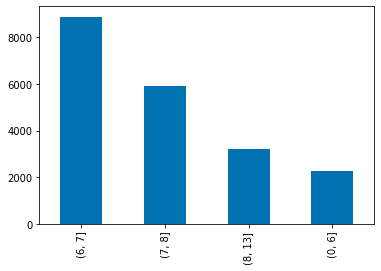

In [28]:
bins_grade = bins_grade.cat.as_ordered()
print(bins_grade)
bins_grade.value_counts().plot(kind='bar')

In [29]:
# Replace existing 'grade' column
data['grade'] = bins_grade

### Bathrooms

In [30]:
data.bathrooms.describe()

count    20268.000000
mean         2.054347
std          0.709689
min          0.500000
25%          1.500000
50%          2.000000
75%          2.500000
max          7.500000
Name: bathrooms, dtype: float64

In [31]:
bins = [0, 1, 2, 3, 8]

In [32]:
# Use pd.cut()
bins_bath = pd.cut(data['bathrooms'], bins)
# Using pd.cut() returns unordered categories. Transform this to ordered categories 
bins_bath = bins_bath.cat.as_ordered()
bins_bath.head()

0    (0, 1]
1    (2, 3]
2    (0, 1]
3    (2, 3]
4    (1, 2]
Name: bathrooms, dtype: category
Categories (4, interval[int64]): [(0, 1] < (1, 2] < (2, 3] < (3, 8]]

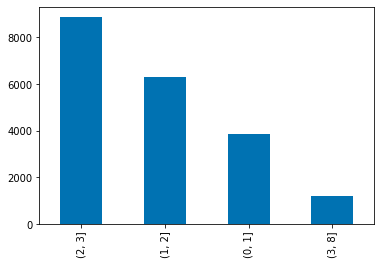

In [33]:
bins_bath.value_counts().plot(kind='bar')

In [34]:
data['bathrooms'] = bins_bath

### Perform Label Encoding

In [35]:
data['grade'] = data['grade'].cat.codes
data['bathrooms'] = data['bathrooms'].cat.codes

In [36]:
data.head()

,price,bathrooms,sqft_living,sqft_living15,sqft_above,grade
0,221900.0,0,1180,1340,1180,1
1,538000.0,2,2570,1690,2170,1
2,180000.0,0,770,2720,770,0
3,604000.0,2,1960,1360,1050,1
4,510000.0,1,1680,1800,1680,2


### Create Dummy Variables

In [37]:
grade_dummy = pd.get_dummies(bins_grade, prefix='Grade', drop_first=True)
bath_dummy = pd.get_dummies(bins_bath, prefix='Bath', drop_first=True)

In [38]:
data = data.drop(['grade', 'bathrooms'], axis=1)

In [39]:
data.head()

,price,sqft_living,sqft_living15,sqft_above
0,221900.0,1180,1340,1180
1,538000.0,2570,1690,2170
2,180000.0,770,2720,770
3,604000.0,1960,1360,1050
4,510000.0,1680,1800,1680


In [40]:
# Create dummy variables for grade column
data = pd.concat([data, grade_dummy, bath_dummy], axis=1)
data.head()

,price,sqft_living,sqft_living15,sqft_above,"Grade_(6, 7]","Grade_(7, 8]","Grade_(8, 13]","Bath_(1, 2]","Bath_(2, 3]","Bath_(3, 8]"
0,221900.0,1180,1340,1180,1,0,0,0,0,0
1,538000.0,2570,1690,2170,1,0,0,0,1,0
2,180000.0,770,2720,770,0,0,0,0,0,0
3,604000.0,1960,1360,1050,1,0,0,0,1,0
4,510000.0,1680,1800,1680,0,1,0,1,0,0


In [41]:
grade_dummy

,"Grade_(6, 7]","Grade_(7, 8]","Grade_(8, 13]"
0,1,0,0
1,1,0,0
2,0,0,0
3,1,0,0
4,0,1,0
...,...,...,...
21415,0,1,0
21416,0,1,0
21417,1,0,0
21418,0,1,0


## Feature Ranking with Recursive Feature Elimination

### Stepwise Function
In stepwise selection, you start with an empty model, and each time, the variable that has an associated parameter estimate with the lowest p-value is added to the model (forward step). After adding each new variable in the model, the algorithm will look at the p-values of all the other parameter estimates which were added to the model previously, and remove them if the p-value exceeds a certain value (backward step). The algorithm stops when no variables can be added or removed given the threshold values.

In [19]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

### Define the Values
Calling the above stepwise function, our features will be evaluated.

In [20]:
X = data.drop(columns='price', axis=1)
#X = data[['sqft_living', 'sqft_living15', 'sqft_above']]
y = data[['price']]

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

Add  sqft_above                     with p-value 0.0
Add  sqft_living                    with p-value 0.0
Drop sqft_above                     with p-value 0.712831
Add  grade                          with p-value 0.0
Add  sqft_above                     with p-value 2.80958e-61
Add  sqft_living15                  with p-value 1.41812e-64
Add  bathrooms                      with p-value 1.90978e-15
resulting features:
['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']


/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


In [21]:
# Select the most important features
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 3)
selector = selector.fit(X, y.values.ravel()) # convert y to 1d np array to prevent DataConversionWarning
selector.support_ 

array([ True,  True, False, False,  True])

In [22]:
selector.ranking_

array([1, 1, 3, 2, 1])

Through the above analysis we find the most important features are sqft_living, grade and bathrooms.

### Evaluate the most important features - Build the Model

In [25]:
# Model with indicated features
X = data[['sqft_living', 'grade', 'bathrooms']]
y = data.price
ols = sm.OLS(y, X)
res = ols.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                          6.838e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):                        0.00
Time:                        01:32:01   Log-Likelihood:                     -2.7115e+05
No. Observations:               20268   AIC:                                  5.423e+05
Df Residuals:                   20265   BIC:                                  5.423e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   132.2550      2.152     61.458      0.000     128.037     136.473
grade         3.45e+04    586.711     58.798      0.000    3.33e+04    3.56e+04
bathrooms   -1.907e+04   2271.292     -8.395      0.000   -2.35e+04   -1.46e+04
==============================================================================
Omnibus:                     1176.294   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1390.183
Skew:                           0.624   Prob(JB):                    1.34e-302
Kurtosis:                       3.296   Cond. No.                     4.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model still indicates multicollinearity. Since bathrooms had the lowest correlation, it will be removed for further evaluation.

In [26]:
# Model with indicated features
X = data[['sqft_living', 'grade']]
y = data.price
ols = sm.OLS(y, X)
res = ols.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                          1.022e+05
Date:                Thu, 05 Mar 2020   Prob (F-statistic):                        0.00
Time:                        01:40:20   Log-Likelihood:                     -2.7119e+05
No. Observations:               20268   AIC:                                  5.424e+05
Df Residuals:                   20266   BIC:                                  5.424e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   122.2439      1.794     68.125      0.000     118.727     125.761
grade        3.192e+04    501.090     63.708      0.000    3.09e+04    3.29e+04
==============================================================================
Omnibus:                     1193.797   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1413.734
Skew:                           0.631   Prob(JB):                    1.03e-307
Kurtosis:                       3.285   Cond. No.                         968.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Fit with sqft_living and grade')

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


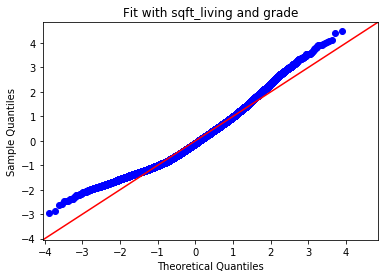

In [32]:
residuals = res.resid
fig = sm.graphics.qqplot(residuals, dist=scs.norm, line='45', fit=True)
plt.title('Fit with sqft_living and grade')
fig.show()

## Visualize grade vs price

<Figure size 1656x936 with 0 Axes>

Text(0.5, 1.0, 'Grade of Homes by Price')

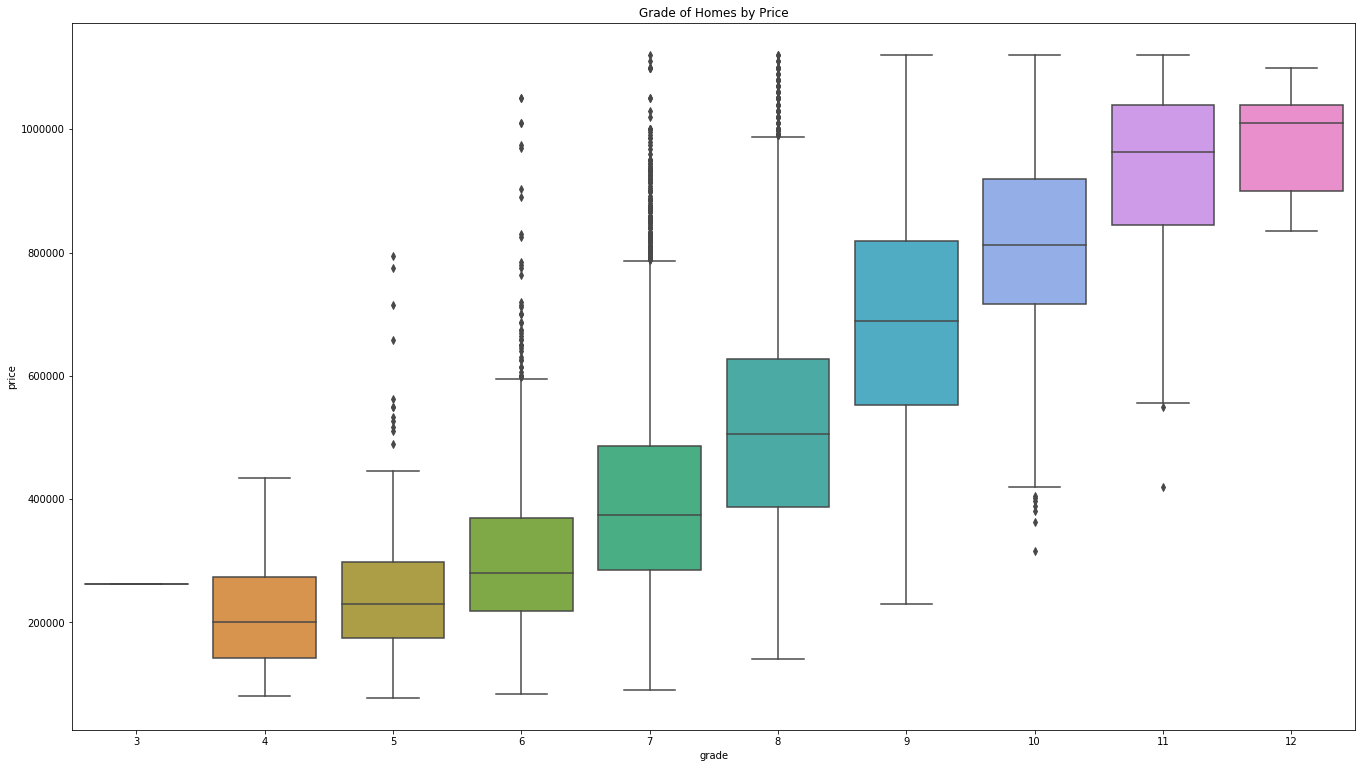

In [49]:
plt.figure(figsize=(23, 13))
gfig = sns.boxplot(x="grade", y="price", data=df_price)
plt.title('Grade of Homes by Price')

Text(0.5, 1.0, 'Homes by Price')

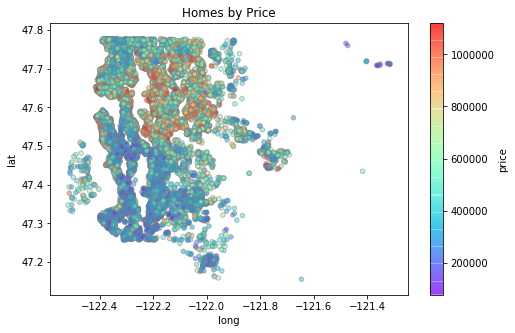

In [50]:
# Color coded plot of homes by price and location
df_price.plot(kind='scatter', x='long', y='lat', alpha=0.5, figsize=(8,5), 
        c='price', cmap='rainbow', colorbar=True, sharex=False, edgecolors='gray');
plt.title('Homes by Price')